<a href="https://colab.research.google.com/github/237Codes/poisoning_attack/blob/main/label_flipping_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


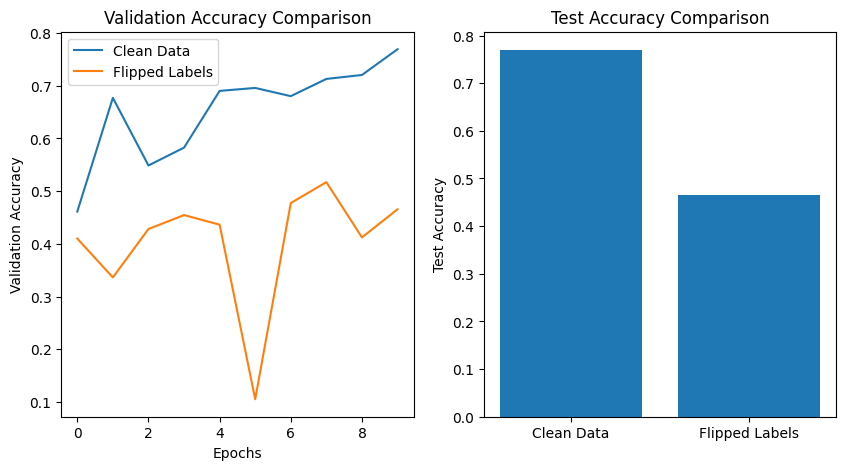

Clean Data Test Accuracy: 0.7695000171661377
Flipped Labels Test Accuracy: 0.46560001373291016


In [ ]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical


# 1. Load and Preprocess Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


# 2. Load Pre-trained ResNet50 (excluding top layer for custom classification)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add custom classification layers
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# 3. Implement Label Flipping Attack
def label_flipping_attack(y, flip_rate):
    num_samples = y.shape[0]
    num_to_flip = int(num_samples * flip_rate)
    indices_to_flip = np.random.choice(num_samples, num_to_flip, replace=False)

    flipped_labels = np.copy(y)

    for i in indices_to_flip:
        # Flip the label to a random class (excluding the original)
        original_class = np.argmax(y[i])
        new_class = np.random.choice([j for j in range(10) if j != original_class])
        flipped_labels[i] = to_categorical(new_class, num_classes = 10)

    return flipped_labels

# 4. Implement Class Mislabeling Attack
def class_mislabeling_attack(y, target_class_from, target_class_to):
    mislabeled_y = np.copy(y)
    for i in range(len(y)):
        if np.argmax(y[i]) == target_class_from:
            mislabeled_y[i] = to_categorical(target_class_to, num_classes = 10)
    return mislabeled_y


# --- Model Training and Evaluation (with comparison) ---

# Define a function for training and evaluation
def train_and_evaluate(model, x_train, y_train, x_test, y_test, epochs=10, batch_size=32):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=1)
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    return history, loss, accuracy


# Train the model without any attack
history_clean, loss_clean, accuracy_clean = train_and_evaluate(model, x_train, y_train, x_test, y_test)

# Train the model with the label flipping attack
y_train_flipped = label_flipping_attack(y_train, 0.2)
history_flipped, loss_flipped, accuracy_flipped = train_and_evaluate(tf.keras.models.clone_model(model), x_train, y_train_flipped, x_test, y_test)


# Plotting the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_clean.history['val_accuracy'], label='Clean Data')
plt.plot(history_flipped.history['val_accuracy'], label='Flipped Labels')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy Comparison')

plt.subplot(1, 2, 2)
plt.bar(['Clean Data', 'Flipped Labels'], [accuracy_clean, accuracy_flipped])
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison')
plt.show()

print(f"Clean Data Test Accuracy: {accuracy_clean}")
print(f"Flipped Labels Test Accuracy: {accuracy_flipped}")

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 116s 45ms/step - accuracy: 0.3053 - loss: 2.1880 - val_accuracy: 0.3828 - val_loss: 2.5713
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 32ms/step - accuracy: 0.4734 - loss: 1.4358 - val_accuracy: 0.4730 - val_loss: 3.0248
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - accuracy: 0.5332 - loss: 1.2908 - val_accuracy: 0.3009 - val_loss: 4.0291
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 30ms/step - accuracy: 0.5704 - loss: 1.2224 - val_accuracy: 0.5098 - val_loss: 3.1944
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - accuracy: 0.5977 - loss: 1.1312 - val_accuracy: 0.3991 - val_loss: 4.6614
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - accuracy: 0.6322 - loss: 1.0486 - val_accuracy: 0.3809 - val_loss: 3.7530
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 31ms/step - accuracy: 0.6531 - loss: 0.9895 - val_accuracy: 0.3549 - val_loss: 3.9521
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 31ms/step - accuracy: 0.5376 

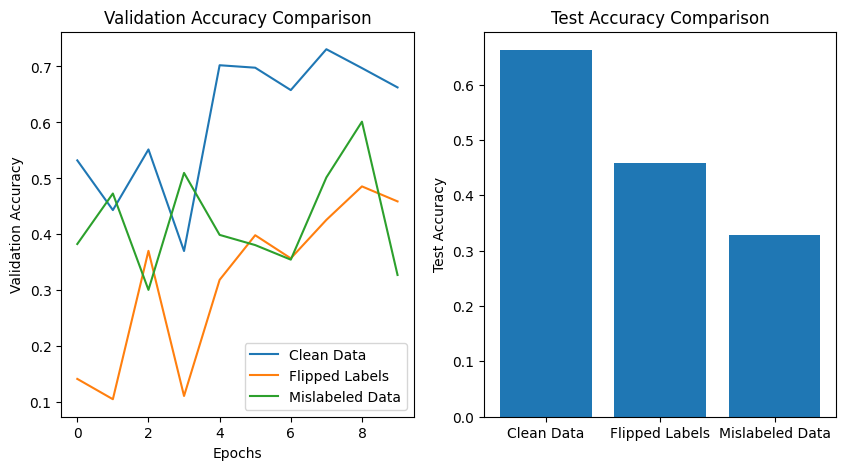

Clean Data Test Accuracy: 0.6625000238418579
Flipped Labels Test Accuracy: 0.45890000462532043
Mislabeled Data Test Accuracy: 0.32749998569488525


In [ ]:
# prompt: take the data from above and impliment a class mislabelling attack

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical



# 1. Load and Preprocess Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


# 2. Load Pre-trained ResNet50 (excluding top layer for custom classification)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add custom classification layers
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# 3. Implement Label Flipping Attack
def label_flipping_attack(y, flip_rate):
    num_samples = y.shape[0]
    num_to_flip = int(num_samples * flip_rate)
    indices_to_flip = np.random.choice(num_samples, num_to_flip, replace=False)

    flipped_labels = np.copy(y)

    for i in indices_to_flip:
        # Flip the label to a random class (excluding the original)
        original_class = np.argmax(y[i])
        new_class = np.random.choice([j for j in range(10) if j != original_class])
        flipped_labels[i] = to_categorical(new_class, num_classes = 10)

    return flipped_labels

# 4. Implement Class Mislabeling Attack
def class_mislabeling_attack(y, target_class_from, target_class_to):
    mislabeled_y = np.copy(y)
    for i in range(len(y)):
        if np.argmax(y[i]) == target_class_from:
            mislabeled_y[i] = to_categorical(target_class_to, num_classes = 10)
    return mislabeled_y


# --- Model Training and Evaluation (with comparison) ---

# Define a function for training and evaluation
def train_and_evaluate(model, x_train, y_train, x_test, y_test, epochs=10, batch_size=32):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=1)
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    return history, loss, accuracy

#Example usage of class mislabeling attack
target_class_from = 3 #Example: change class 3
target_class_to = 8 #Example: to class 8

y_train_mislabeled = class_mislabeling_attack(y_train, target_class_from, target_class_to)

# Train the model with the mislabeling attack
history_mislabeled, loss_mislabeled, accuracy_mislabeled = train_and_evaluate(tf.keras.models.clone_model(model), x_train, y_train_mislabeled, x_test, y_test)

# Train the model without any attack
history_clean, loss_clean, accuracy_clean = train_and_evaluate(model, x_train, y_train, x_test, y_test)

# Train the model with the label flipping attack
y_train_flipped = label_flipping_attack(y_train, 0.2)
history_flipped, loss_flipped, accuracy_flipped = train_and_evaluate(tf.keras.models.clone_model(model), x_train, y_train_flipped, x_test, y_test)


# Plotting the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_clean.history['val_accuracy'], label='Clean Data')
plt.plot(history_flipped.history['val_accuracy'], label='Flipped Labels')
plt.plot(history_mislabeled.history['val_accuracy'], label='Mislabeled Data')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy Comparison')

plt.subplot(1, 2, 2)
plt.bar(['Clean Data', 'Flipped Labels', 'Mislabeled Data'], [accuracy_clean, accuracy_flipped, accuracy_mislabeled])
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison')
plt.show()

print(f"Clean Data Test Accuracy: {accuracy_clean}")
print(f"Flipped Labels Test Accuracy: {accuracy_flipped}")
print(f"Mislabeled Data Test Accuracy: {accuracy_mislabeled}")